# Assignment

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [3]:
np.random.seed(1)

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS (OUTPUT)

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

# initialization of the network
xavier = False

if xavier:
    W1 = np.random.randn(N_h, N_in) * np.sqrt(1 / N_in)
    W2 = np.random.randn(N_a, N_h) * np.sqrt(1 / N_h)
else:
    W1 = np.random.uniform(0, 1, (N_h, N_in))
    W1 = np.divide(W1, np.tile(np.sum(W1, 1)[:, None], (1, N_in)), )
    
    W2 = np.random.uniform(0,1,(N_a, N_h))
    W2 = np.divide(W2, np.tile(np.sum(W2, 1)[:, None], (1,N_h)), )

bias_W1 = np.zeros((N_h,))
bias_W2 = np.zeros((N_a,))

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [4]:
# define the epsilon - greedy policy

def EpsilonGreedy_Policy(Qvalues, epsilon):
    
    N_a=np.shape(Qvalues)[0]

    rand_value=np.random.uniform(0,1)

    rand_a=rand_value<epsilon

    if rand_a==True:
        # random action with epsilon
        a=np.random.randint(0,N_a)

    else:
        # Greedy with probability epsilon
        a=np.argmax(Qvalues)
            
    return a

In [5]:
# Parameter to choose between the implemented algorithms
# SARSA

# the training loop is run N_episodes times
for n in range(N_episodes):
    
    if n%5000 == 0 and n > 0:
        print("Episode ", n)
        print('Avg. reward last 1000 episodes:')
        print('Average reward:',np.mean(R_save[n-1000:n]),'Number of steps: ',np.mean(N_moves_save[n-1000:n]))

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    # get the initial state of the environment (initial board position)
    S,X,allowed_a=env.Initialise_game()   
    
    # network forward pass: the Q values are calculated as the output of the network feeded with
    # the features vector. The network has one hidden layer with 200 units and Relu as activation
    # function
    x0 = X
    h1 = np.dot(W1,x0) + bias_W1
    x1 = np.maximum(h1, 0)
    h2 = np.dot(W2,x1) + bias_W2
    x2 = np.maximum(h2, 0)

    # pick an action from the allowed ones following the epsilon-greedy policy
    allowed_a_index,_=np.where(allowed_a==1)
    a = EpsilonGreedy_Policy(x2[allowed_a_index], epsilon_f) 
    taken_action = allowed_a_index[a]
    
    # while there is no check mate or draw
    while Done==0:                           
        
        Q_a = x2[taken_action]
                
        # take the chosen action: observe new values
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(taken_action)
        
        # if there is check mate or draw
        if Done==1:
            
            # create vector with action taken = 1 rest = 0
            action_taken = np.zeros(len(x2))
            action_taken[taken_action] = 1

            # update network parameters only for the action neuron
            e_n = (R - Q_a) * action_taken

            # The parameters W2 and b2 are updated only for the taken action
            delta2 = x2*(1-x2) * e_n
                
            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1,x0)
            dbias_W1 = delta1

            # After each batch update the weights using accumulated gradients
            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            # save the reward (check mate = 1; draw = 0) and the steps of the episode
            R_save[n] = np.copy(R)
            N_moves_save[n] = np.copy(i)
            
            break
        
        
        # if the game is not over
        else:
            
            # network forward pass to calculate the next Q values
            x0_next = X_next
            h1_next = np.dot(W1,x0_next) + bias_W1
            x1_next = np.maximum(h1_next, 0)
            h2_next = np.dot(W2,x1_next) + bias_W2
            x2_next = np.maximum(h2_next, 0)
            
            # pick a new action with epsilon-greedy policy
            allowed_a_index,_=np.where(allowed_a_next==1)
            a = EpsilonGreedy_Policy(x2_next[allowed_a_index],epsilon_f) 
            taken_action2 = allowed_a_index[a]
            Q_a2 = x2_next[taken_action2]
            
            # create vector size: output, with action taken = 1 rest = 0
            action_taken = np.zeros(len(x2))
            action_taken[taken_action] = 1

            #update network parameters only for the action neuron (SARSA)            
            e_n = (R + gamma*Q_a2 - Q_a) * action_taken
                
            # Backpropagation: output layer -> hidden layer
            delta2 = x2*(1-x2) * e_n
                
            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1,x0)
            dbias_W1 = delta1

            # After each batch update the weights using accumulated gradients
            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            
        # save values for the next step iteration   
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        taken_action = np.copy(taken_action2)
        h1 = np.copy(h1_next)
        x1 = np.copy(x1_next)
        h2 = np.copy(h2_next)
        x2 = np.copy(x2_next)
        
        i += 1  # uptate the number of steps in the episode

Episode  5000
Avg. reward last 1000 episodes:
Average reward: 0.425 Number of steps:  7.475
Episode  10000
Avg. reward last 1000 episodes:
Average reward: 0.441 Number of steps:  7.726
Episode  15000
Avg. reward last 1000 episodes:
Average reward: 0.495 Number of steps:  8.78
Episode  20000
Avg. reward last 1000 episodes:
Average reward: 0.435 Number of steps:  7.082
Episode  25000
Avg. reward last 1000 episodes:
Average reward: 0.469 Number of steps:  7.263
Episode  30000
Avg. reward last 1000 episodes:
Average reward: 0.409 Number of steps:  12.746
Episode  35000
Avg. reward last 1000 episodes:
Average reward: 0.43 Number of steps:  7.699
Episode  40000
Avg. reward last 1000 episodes:
Average reward: 0.435 Number of steps:  9.942
Episode  45000
Avg. reward last 1000 episodes:
Average reward: 0.461 Number of steps:  10.073
Episode  50000
Avg. reward last 1000 episodes:
Average reward: 0.466 Number of steps:  10.603
Episode  55000
Avg. reward last 1000 episodes:
Average reward: 0.478 N

In [6]:
print('Total:')
print('Average reward:',np.mean(R_save[:]),'Number of steps: ',np.mean(N_moves_save[:]))
print('In the last 1000 episodes:')
print('Average reward:',np.mean(R_save[-1000:]),'Number of steps: ',np.mean(N_moves_save[-1000:]))

Total:
Average reward: 0.45639 Number of steps:  10.74212
In the last 1000 episodes:
Average reward: 0.522 Number of steps:  15.288


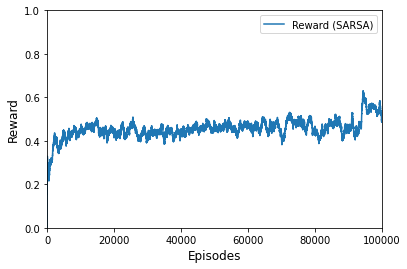

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

plt.xlim([0, N_episodes])
plt.ylim([0, 1])
plt.rcParams['axes.linewidth'] = 0.75
 
# dataframe
n_moves = pd.DataFrame({'Reward': list(R_save)})
 
ema = n_moves.ewm(com=400).mean()
 

plt.plot(ema, label="Reward (SARSA)")
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.legend()

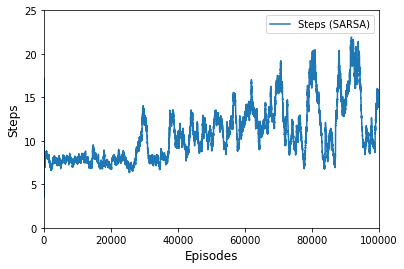

In [8]:
# dataframe
n_moves = pd.DataFrame({'N_moves_save': list(N_moves_save)})

plt.xlim([0, N_episodes])
plt.ylim([0, 25])
 
ema = n_moves.ewm(com=400).mean()
 

plt.plot(ema, label="Steps (SARSA)")
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Steps", fontsize=12)
plt.legend()